Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2022-12-02 по 2022-12-08 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные АB-теста. 

Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали? 
Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.
Ваше решение — это ссылка на merge request с проведенным анализом.

In [1]:
import pandas as pd
import pandahouse as ph
import numpy as np
from tqdm import tqdm
import scipy.stats as stats

In [2]:
import seaborn as sns

In [3]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20221220',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [4]:
#загружаем данные за 2 - 8 декабря по 1 и 2-й экспериментальных групп
q = """
SELECT exp_group,
user_id,
sum(action = 'like') as likes,
sum(action = 'view') as views,
likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2022-12-02' and '2022-12-08'
and exp_group in (2,1)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


In [5]:
'''вначале посчитаем ctr в двух группах'''
df[df['exp_group'] == 1].ctr.mean(), df[df['exp_group'] == 2].ctr.mean()

(0.21560459841296287, 0.21441927347479375)

получаем результат, что средний ctr в 1-й группе выше, хотя, по условию 
гипотеза в том, что алгоритм во второй группе приведет к увеличению ctr. 
Посмотрим на распределение ctr в группах на графике.

In [6]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

<AxesSubplot:xlabel='ctr', ylabel='Count'>

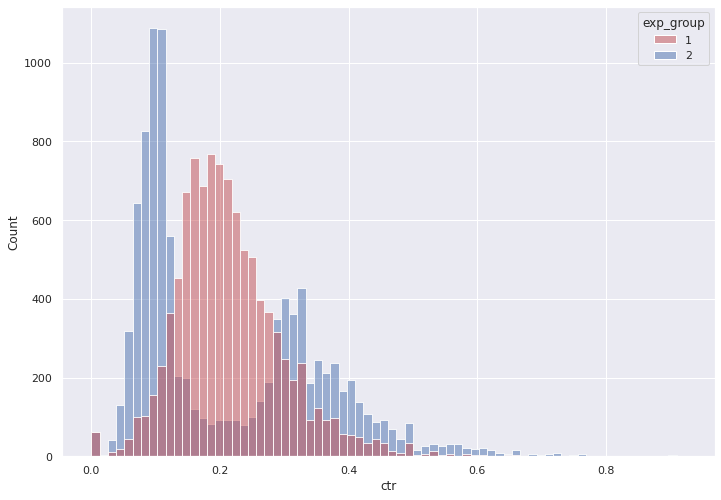

In [7]:
sns.histplot(data =df,
x='ctr',
hue='exp_group',
palette = ['r', 'b'],
alpha=0.5,
kde=False)

Как мы видим, что в отличие от контрольной группы, распределение во 2й группе бимодальное. Причем первая мода с ctr ниже чем в контрольной группе, вторая мода с ctr выше. Возможно, у какой-то отдельной группы пользователей новый алгоритм работает некорректно, в связи с чем их ctr ниже. Попробуем проверить, загрузив данные, которые у нас есть по пользователям.

In [8]:
q2 = """
SELECT
user_id,
source,
country,
os,
exp_group,
sum(action = 'like') as likes,
sum(action = 'view') as views,
likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2022-12-02' and '2022-12-08'
and exp_group in (1,2)
GROUP BY user_id, exp_group, source, country, os
"""

df2 = ph.read_clickhouse(q2, connection=connection)
df2.head()

,user_id,source,country,os,exp_group,likes,views,ctr
0,118685,organic,Russia,Android,1,12,51,0.235294
1,128479,organic,Russia,Android,2,16,22,0.727273
2,125315,organic,Ukraine,Android,1,9,92,0.097826
3,121687,organic,Russia,Android,2,10,27,0.370370
4,113901,organic,Russia,iOS,2,3,29,0.103448


In [9]:
#выделим отдельно 2 и 1ю группы
df3 = df2[df2['exp_group']==2]
df4 = df2[df2['exp_group']==1]

In [10]:
#посмотрим есть ли какие-то отклонения в ctr в зависимости от ресурса
df3[df3['source'] == 'ads'].ctr.mean(), df3[df3['source'] == 'organic'].ctr.mean(), df4[df4['source'] == 'ads'].ctr.mean(), df4[df4['source'] == 'organic'].ctr.mean()

(0.2155885979694554,
 0.2133753767121574,
 0.2181787802316975,
 0.2133373585950066)

In [11]:
#проверим зависимость от ОС
df3[df3['os'] == 'Android'].ctr.mean(), df3[df3['os'] == 'iOS'].ctr.mean()

(0.21610174901867096, 0.21137581150451182)

*Итого заключаем, что особых отклонений выявлено не было. Алгоритм работает хорошо на одной группе пользователей,однако, ухудшает метрику по другой группе. Выявить характеристику пользователей, у которых алгоритм работает плохо не получилось. Возможно, стоит запросить данные о пользователях в зависимости от использования мобильного приложения или ПК.*

*Посмотрим, будет ли сглаженный ctr в контрольной группе также выше, чем в тестовой.*

In [12]:
#пишем функцию сглаженного ctr
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [13]:
#считаем ctr по группам
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()
global_ctr_1, global_ctr_2

(0.20802680490126244, 0.1980601844115994)

In [14]:
df3 = df2[df2['exp_group']==2].copy()
df4 = df2[df2['exp_group']==1].copy()

In [15]:
#рассчитываем сглаженный ctr для пользователей. Гиперапаметр возьмем как в лекции.
df3['smoothed_CTR'] = df3.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
df4['smoothed_CTR'] = df4.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

In [16]:
df3.head()

,user_id,source,country,os,exp_group,likes,views,ctr,smoothed_CTR
1,128479,organic,Russia,Android,2,16,22,0.727273,0.631116
3,121687,organic,Russia,Android,2,10,27,0.370370,0.345004
4,113901,organic,Russia,iOS,2,3,29,0.103448,0.118827
6,112724,organic,Russia,iOS,2,25,85,0.294118,0.289335
7,11766,ads,Russia,Android,2,9,74,0.121622,0.127090


In [17]:
df4.head()

,user_id,source,country,os,exp_group,likes,views,ctr,smoothed_CTR
0,118685,organic,Russia,Android,1,12,51,0.235294,0.232860
2,125315,organic,Ukraine,Android,1,9,92,0.097826,0.103507
5,22411,ads,Russia,iOS,1,8,45,0.177778,0.180803
9,32833,ads,Russia,Android,1,22,90,0.244444,0.242528
10,125762,organic,Russia,iOS,1,6,19,0.315789,0.293339


In [18]:
#Проверим в какой группе ctr выше
df3.smoothed_CTR.mean(), df4.smoothed_CTR.mean()

(0.21181083533531964, 0.21402549608884142)

Итого сглаженный ctr, также как и обычный ctr выше в контрольной группе. Проверим, статистическую значимость разницы ctr в контрольной и тестовой группах. Ввиду того, что данных не очень много (в группах не миллионы пользователей), используем метод пуассоновского бутстрепа.

In [19]:
#Функция бутсрепа в которой выбранное число раз по пуассоновскому распределению(1) 
#строится массив из количеств раз, сколько каждый пользователь попадается в подвыборках.
#Далее каждый раз считается групповой ctr по каждой группе и разница ctr заносится в список, 
#который выдает функция на выходе
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    res=[]
    for _ in tqdm(range(n_bootstrap)):
        poisson_bootstraps1 = np.random.poisson(1,len(likes1))
        poisson_bootstraps2 = np.random.poisson(1,len(likes2))
        globalCTR1 = (poisson_bootstraps1*likes1).sum()/(poisson_bootstraps1*views1).sum()
        globalCTR2 = (poisson_bootstraps2*likes2).sum()/(poisson_bootstraps2*views2).sum()
        res.append(globalCTR2 - globalCTR1)
    return res

In [20]:
#считаем лайки и просмотры по каждой группе
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [21]:
#получаем список из разниц групповых ctr
np.random.seed(5)
res = bootstrap(likes1, views1, likes2, views2)

100%|██████████| 2000/2000 [00:04<00:00, 438.73it/s]


<AxesSubplot:ylabel='Count'>

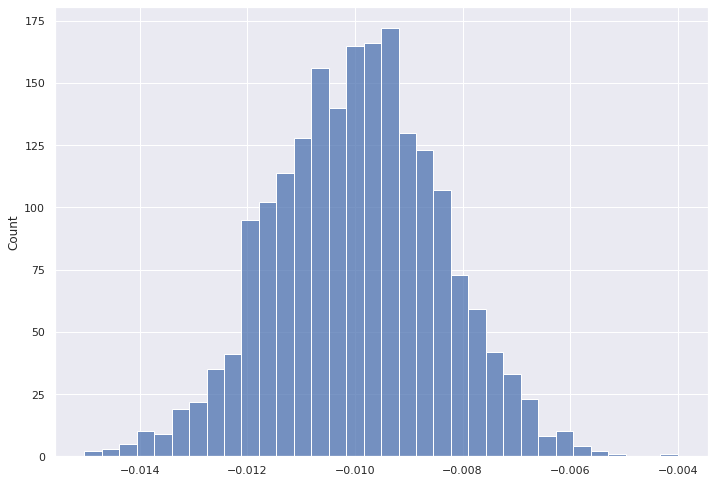

In [22]:
#строим гистрограмму
sns.histplot(res)

Как мы видим на гистрограмме 0 не входим в распределение разницы ctr между контрольной и тестовой группами. Заключаем, что разница ctr между группами статичтически значима, ctr в контрольной группе выше чем ctr в тестовой группе.

**Вывод: Гипотеза об увеличении ctr вследствие введения нового алгоритма не подтвердилась. Более того, зафиксировано статистически значимое снижение ctr в тестовой группе. Раскатка алгоритма на всех пользователей не рекомендована.**

В условии задания сказано: "сравните данные этими тестами". Чтобы выполнить задание, несмотря на то, что вывод сделан (вверху) проведем оценку статистической значимости бакетным преобразованием (в любой случае вывод по алгоритму сделан!). 

In [23]:
import hashlib

In [24]:
#разобьем пользователей на 50 корзин методом хэширования "с солью" 
def ab_split(id, salt='exp_mess_1', n_groups=50):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [25]:
df['hash_group'] = df.user_id.apply(ab_split)

In [26]:
df.head()

,exp_group,user_id,likes,views,ctr,hash_group
0,1,109963,3,15,0.200000,10
1,1,26117,32,141,0.226950,19
2,1,138232,18,73,0.246575,31
3,1,26295,33,122,0.270492,14
4,1,18392,7,32,0.218750,1


In [27]:
#сгруппируем пользователей по корзинам
df5 = df.groupby(['hash_group','exp_group'], as_index=False).agg({'likes' : 'sum', 'views' : 'sum'})
df5['b_ctr'] =  df5['likes']/df5['views']
df5.head()

,hash_group,exp_group,likes,views,b_ctr
0,0,1,2993,13872,0.215758
1,0,2,2399,11979,0.200267
2,1,1,2873,13602,0.211219
3,1,2,2183,12372,0.176447
4,2,1,3055,14802,0.206391


<AxesSubplot:xlabel='b_ctr', ylabel='Count'>

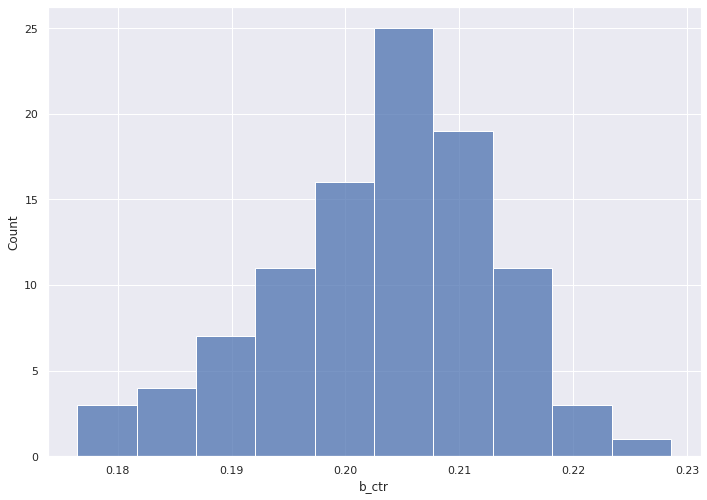

In [28]:
#посмотрим на гистограмму распределения бакетного ctr
sns.histplot(df5.b_ctr)

In [29]:
#распределение приблизительно напоминает нормальное 
#(соответственно, можно предположить, что и разница ctr будет походить на нормальное). 
#Применим t-тест. 
stats.ttest_ind(df5[df5.exp_group == 1].b_ctr,
df5[df5.exp_group == 2].b_ctr,
equal_var = False)

Ttest_indResult(statistic=5.741526456221474, pvalue=1.937624902064435e-07)

t-тест также фиксирует статистически значимую разницу между контрольной и тестовой группами